In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("nsw_property_data.csv")
df

,property_id,download_date,council_name,purchase_price,address,post_code,property_type,strata_lot_number,property_name,area,area_type,contract_date,settlement_date,nature_of_property,primary_purpose,legal_description
0,1216810.0,2023-02-27,CABONNE,3200000.0,"5796 MITCHELL HWY, LARRAS LEE",2866.0,house,NaN,THREE RIVERS,147.20,H,2022-10-20,2022-12-05,R,RESIDENCE,PT 2/630113
1,1217803.0,2023-02-27,CABONNE,410000.0,"53 BANK ST, MOLONG",2866.0,house,NaN,NaN,2023.00,M,2023-02-20,2023-02-21,3,COMMERCIAL,12/25/758693
2,3380305.0,2023-02-27,CABONNE,4125000.0,"244 CROCKETTS LANE, LARRAS LEE",2866.0,house,NaN,BONNIE DOON,213.38,H,2022-07-28,2023-02-20,R,RESIDENCE,84/756908
3,2082468.0,2023-02-27,WOOLLAHRA,1450000.0,"2/110 CASCADE ST, PADDINGTON",2021.0,unit,2.0,NaN,123.00,M,2022-12-09,2023-02-17,R,RESIDENCE,2/SP19410
4,2080204.0,2023-02-27,WOOLLAHRA,2400000.0,"2/6 BERESFORD RD, ROSE BAY",2029.0,unit,2.0,NaN,198.80,M,2022-10-20,2023-02-23,R,RESIDENCE,2/SP5601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308537,3132959.0,2004-12-16,WOLLONGONG,315000.0,"16 BALMER CRES, WOONONA",2517.0,house,NaN,NaN,692.60,M,2004-08-13,2004-12-03,R,RESIDENCE,130/1075519
2308538,3134370.0,2004-12-16,WOLLONGONG,495000.0,"40/4 BANK ST, WOLLONGONG",2500.0,unit,40.0,NaN,NaN,NaN,2003-02-18,2004-12-08,R,RESIDENCE,40/SP73641
2308539,3135607.0,2004-12-16,WOLLONGONG,490000.0,"HOLLYMOUNT VIEW, WOONONA",2517.0,house,NaN,NaN,677.30,M,2004-06-09,2004-12-01,V,VACANT LAND,801/1069433
2308540,3137396.0,2004-12-16,WOLLONGONG,190000.0,"1/186 BALGOWNIE RD, BALGOWNIE",2519.0,unit,1.0,NaN,NaN,NaN,2004-05-27,2004-11-29,R,RESIDENCE,1/SP73961


In [7]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308542 entries, 0 to 2308541
Columns: 16 entries, property_id to legal_description
dtypes: float64(5), object(11)
memory usage: 281.8+ MB


In [8]:
print(df.columns)

Index(['property_id', 'download_date', 'council_name', 'purchase_price',
       'address', 'post_code', 'property_type', 'strata_lot_number',
       'property_name', 'area', 'area_type', 'contract_date',
       'settlement_date', 'nature_of_property', 'primary_purpose',
       'legal_description'],
      dtype='object')


In [9]:
print(df.dtypes)

property_id           float64
download_date          object
council_name           object
purchase_price        float64
address                object
post_code             float64
property_type          object
strata_lot_number     float64
property_name          object
area                  float64
area_type              object
contract_date          object
settlement_date        object
nature_of_property     object
primary_purpose        object
legal_description      object
dtype: object


In [10]:
df.describe()

,property_id,purchase_price,post_code,strata_lot_number,area
count,2.304446e+06,2.308424e+06,2.306534e+06,789517.000000,1.590395e+06
mean,2.140629e+06,8.299326e+05,2.340504e+03,39.152795,7.860101e+02
std,1.260502e+06,5.728578e+06,2.469898e+02,66.394894,1.305813e+03
min,2.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000e-01
25%,1.042994e+06,2.770000e+05,2.141000e+03,4.000000,3.351000e+02
50%,2.123220e+06,4.530000e+05,2.264000e+03,12.000000,6.000000e+02
75%,3.160875e+06,7.400000e+05,2.539000e+03,43.000000,8.044000e+02
max,4.475936e+06,8.870846e+08,5.871000e+03,1262.000000,6.305000e+05


In [11]:
unique_council_name_counts = df['council_name'].value_counts()
unique_council_name_counts_df = unique_council_name_counts.to_frame()
print(unique_council_name_counts_df)

                 council_name
BLACKTOWN               88898
CITY OF SYDNEY          85572
SUTHERLAND              57947
LAKE MACQUARIE          55336
THE HILLS SHIRE         55223
...                       ...
623                        30
185                        22
695                        15
077                         9
722                         1

[219 rows x 1 columns]


## check for missing values

In [12]:
null_count=df.isnull().sum()
print(null_count)

property_id              4096
download_date               0
council_name                0
purchase_price            118
address                     0
post_code                2008
property_type               0
strata_lot_number     1519025
property_name         2238111
area                   718147
area_type              718187
contract_date             230
settlement_date             5
nature_of_property          0
primary_purpose         46768
legal_description        4697
dtype: int64


## drop columns with the most missing values

In [16]:
df.drop(['property_name', 'strata_lot_number'], axis=1, inplace=True)

In [17]:
df

,property_id,download_date,council_name,purchase_price,address,post_code,property_type,area,area_type,contract_date,settlement_date,nature_of_property,primary_purpose,legal_description
0,1216810.0,2023-02-27,CABONNE,3200000.0,"5796 MITCHELL HWY, LARRAS LEE",2866.0,house,147.200000,H,2022-10-20,2022-12-05,R,RESIDENCE,PT 2/630113
1,1217803.0,2023-02-27,CABONNE,410000.0,"53 BANK ST, MOLONG",2866.0,house,2023.000000,M,2023-02-20,2023-02-21,3,COMMERCIAL,12/25/758693
2,3380305.0,2023-02-27,CABONNE,4125000.0,"244 CROCKETTS LANE, LARRAS LEE",2866.0,house,213.380000,H,2022-07-28,2023-02-20,R,RESIDENCE,84/756908
3,2082468.0,2023-02-27,WOOLLAHRA,1450000.0,"2/110 CASCADE ST, PADDINGTON",2021.0,unit,123.000000,M,2022-12-09,2023-02-17,R,RESIDENCE,2/SP19410
4,2080204.0,2023-02-27,WOOLLAHRA,2400000.0,"2/6 BERESFORD RD, ROSE BAY",2029.0,unit,198.800000,M,2022-10-20,2023-02-23,R,RESIDENCE,2/SP5601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308537,3132959.0,2004-12-16,WOLLONGONG,315000.0,"16 BALMER CRES, WOONONA",2517.0,house,692.600000,M,2004-08-13,2004-12-03,R,RESIDENCE,130/1075519
2308538,3134370.0,2004-12-16,WOLLONGONG,495000.0,"40/4 BANK ST, WOLLONGONG",2500.0,unit,786.010148,NaN,2003-02-18,2004-12-08,R,RESIDENCE,40/SP73641
2308539,3135607.0,2004-12-16,WOLLONGONG,490000.0,"HOLLYMOUNT VIEW, WOONONA",2517.0,house,677.300000,M,2004-06-09,2004-12-01,V,VACANT LAND,801/1069433
2308540,3137396.0,2004-12-16,WOLLONGONG,190000.0,"1/186 BALGOWNIE RD, BALGOWNIE",2519.0,unit,786.010148,NaN,2004-05-27,2004-11-29,R,RESIDENCE,1/SP73961


In [16]:
null_count=df.isnull().sum()
print(null_count)

property_id             4096
download_date              0
council_name               0
purchase_price           118
address                    0
post_code               2008
property_type              0
area                  718147
area_type             718187
contract_date            230
settlement_date            5
nature_of_property         0
primary_purpose        46768
legal_description       4697
dtype: int64


## replace missing values in area column with the mean of the column.

In [18]:
mean_area = df['area'].mean()
df['area'].fillna(mean_area, inplace=True)

In [19]:
null_count=df.isnull().sum()
print(null_count)

property_id             4096
download_date              0
council_name               0
purchase_price           118
address                    0
post_code               2008
property_type              0
area                       0
area_type             718187
contract_date            230
settlement_date            5
nature_of_property         0
primary_purpose        46768
legal_description       4697
dtype: int64


## drop rows with a missing value

In [20]:
num_missing = df.isnull().any(axis=1).sum()

print(f"Number of rows with at least one missing value: {num_missing}")

Number of rows with at least one missing value: 751171


In [21]:
# Drop 751171 rows with any missing values
df.dropna(inplace=True)

In [22]:
null_count=df.isnull().sum()
print(null_count)

property_id           0
download_date         0
council_name          0
purchase_price        0
address               0
post_code             0
property_type         0
area                  0
area_type             0
contract_date         0
settlement_date       0
nature_of_property    0
primary_purpose       0
legal_description     0
dtype: int64


In [24]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557371 entries, 0 to 2308541
Columns: 14 entries, property_id to legal_description
dtypes: float64(4), object(10)
memory usage: 178.2+ MB


## set property_id as index.

In [25]:
df.set_index('property_id', inplace=True)

In [26]:
df.head()

,download_date,council_name,purchase_price,address,post_code,property_type,area,area_type,contract_date,settlement_date,nature_of_property,primary_purpose,legal_description
property_id,,,,,,,,,,,,,
1216810.0,2023-02-27,CABONNE,3200000.0,"5796 MITCHELL HWY, LARRAS LEE",2866.0,house,147.20,H,2022-10-20,2022-12-05,R,RESIDENCE,PT 2/630113
1217803.0,2023-02-27,CABONNE,410000.0,"53 BANK ST, MOLONG",2866.0,house,2023.00,M,2023-02-20,2023-02-21,3,COMMERCIAL,12/25/758693
3380305.0,2023-02-27,CABONNE,4125000.0,"244 CROCKETTS LANE, LARRAS LEE",2866.0,house,213.38,H,2022-07-28,2023-02-20,R,RESIDENCE,84/756908
2082468.0,2023-02-27,WOOLLAHRA,1450000.0,"2/110 CASCADE ST, PADDINGTON",2021.0,unit,123.00,M,2022-12-09,2023-02-17,R,RESIDENCE,2/SP19410
2080204.0,2023-02-27,WOOLLAHRA,2400000.0,"2/6 BERESFORD RD, ROSE BAY",2029.0,unit,198.80,M,2022-10-20,2023-02-23,R,RESIDENCE,2/SP5601


In [28]:
# Convert 'property_id' to integer
df.reset_index(inplace=True)
df['property_id'] = df['property_id'].astype(int)
df.set_index('property_id', inplace=True)

In [29]:
df.head()

,download_date,council_name,purchase_price,address,post_code,property_type,area,area_type,contract_date,settlement_date,nature_of_property,primary_purpose,legal_description
property_id,,,,,,,,,,,,,
1216810,2023-02-27,CABONNE,3200000.0,"5796 MITCHELL HWY, LARRAS LEE",2866.0,house,147.20,H,2022-10-20,2022-12-05,R,RESIDENCE,PT 2/630113
1217803,2023-02-27,CABONNE,410000.0,"53 BANK ST, MOLONG",2866.0,house,2023.00,M,2023-02-20,2023-02-21,3,COMMERCIAL,12/25/758693
3380305,2023-02-27,CABONNE,4125000.0,"244 CROCKETTS LANE, LARRAS LEE",2866.0,house,213.38,H,2022-07-28,2023-02-20,R,RESIDENCE,84/756908
2082468,2023-02-27,WOOLLAHRA,1450000.0,"2/110 CASCADE ST, PADDINGTON",2021.0,unit,123.00,M,2022-12-09,2023-02-17,R,RESIDENCE,2/SP19410
2080204,2023-02-27,WOOLLAHRA,2400000.0,"2/6 BERESFORD RD, ROSE BAY",2029.0,unit,198.80,M,2022-10-20,2023-02-23,R,RESIDENCE,2/SP5601


In [30]:
df.describe()

,purchase_price,post_code,area
count,1.557371e+06,1.557371e+06,1.557371e+06
mean,8.988665e+05,2.398243e+03,7.831338e+02
std,6.486413e+06,2.444875e+02,1.298751e+03
min,0.000000e+00,0.000000e+00,1.000000e-01
25%,2.700000e+05,2.177000e+03,3.347000e+02
50%,4.600000e+05,2.350000e+03,6.000000e+02
75%,7.850000e+05,2.572000e+03,8.031000e+02
max,8.870846e+08,5.871000e+03,6.305000e+05


In [34]:
# Group by 'primary_purpose' and calculate the mean of 'purchase_price'
mean_prices = df.groupby('primary_purpose')['purchase_price'].mean()
mean_prices

primary_purpose
 LOT 1 ONLY              500.0
 LOT 1 RESIDENCE      380000.0
 RESIDENCE            248750.0
 VACANT POSSESSION    188000.0
"RESTAURANT           557500.0
                        ...   
YOUTH  HOSTEL         492000.0
YURT                  200000.0
ZHNP                  337000.0
ZONE                   28500.0
ZOO                   300000.0
Name: purchase_price, Length: 5655, dtype: float64

In [36]:
# Convert the Series to DataFrame and transpose it
mean_prices_df = mean_prices.to_frame().transpose()
mean_prices_df

primary_purpose,LOT 1 ONLY,LOT 1 RESIDENCE,RESIDENCE,VACANT POSSESSION,"""RESTAURANT","""THE BRAE""","""TIMAROO""",$ - 1/434564 & 30/75,$ - 14/1045305 ONLY.,$ - 16/1045305 ONLY.,...,YARD,YARD & OFFICE,YARDS,YINEYARD,YORMER,YOUTH HOSTEL,YURT,ZHNP,ZONE,ZOO
purchase_price,500.0,380000.0,248750.0,188000.0,557500.0,252000.0,520000.0,750000.0,159000.0,159000.0,...,1396250.0,500000.0,200000.0,450000.0,1580000.0,492000.0,200000.0,337000.0,28500.0,300000.0


## Tread analysis. analysis of purchase price over the years.

In [38]:
# Convert 'settlement_date' to datetime
df['settlement_date'] = pd.to_datetime(df['settlement_date'])

# Extract year from 'settlement_date'
df['settlement_year'] = df['settlement_date'].dt.year

# Group by 'settlement_year' and calculate the number of purchases
purchases_per_year = df.groupby('settlement_year').size()
purchases_per_year

settlement_year
1903        1
1911        3
1912        1
1913        3
1914        3
        ...  
2019    65703
2020    74086
2021    92715
2022    75526
2023    13163
Length: 72, dtype: int64

In [41]:
# Filter the data to only include years from 2001 onwards
purchases_per_year_from_2001 = purchases_per_year[purchases_per_year.index >= 2001]
purchases_per_year_from_2001

settlement_year
2001    52893
2002    79926
2003    75696
2004    60069
2005    54919
2006    58547
2007    67936
2008    59740
2009    63376
2010    59173
2011    56497
2012    58855
2013    69413
2014    82942
2015    81351
2016    99309
2017    81557
2018    71853
2019    65703
2020    74086
2021    92715
2022    75526
2023    13163
dtype: int64

In [42]:
# Group by 'settlement_year' and calculate the mean of 'purchase_price'
average_price_per_year = df.groupby('settlement_year')['purchase_price'].mean()

# Filter the data to only include years from 2001 onwards
average_price_per_year_from_2001 = average_price_per_year[average_price_per_year.index >= 2001]
average_price_per_year_from_2001

settlement_year
2001    3.654929e+05
2002    4.781163e+05
2003    4.401674e+05
2004    5.428512e+05
2005    5.823860e+05
2006    6.372244e+05
2007    7.480883e+05
2008    6.510469e+05
2009    6.183590e+05
2010    7.622886e+05
2011    6.676686e+05
2012    7.413786e+05
2013    7.578543e+05
2014    8.197137e+05
2015    9.502545e+05
2016    1.033817e+06
2017    1.248256e+06
2018    1.183399e+06
2019    1.808552e+06
2020    1.219686e+06
2021    1.307303e+06
2022    1.505077e+06
2023    1.412312e+06
Name: purchase_price, dtype: float64

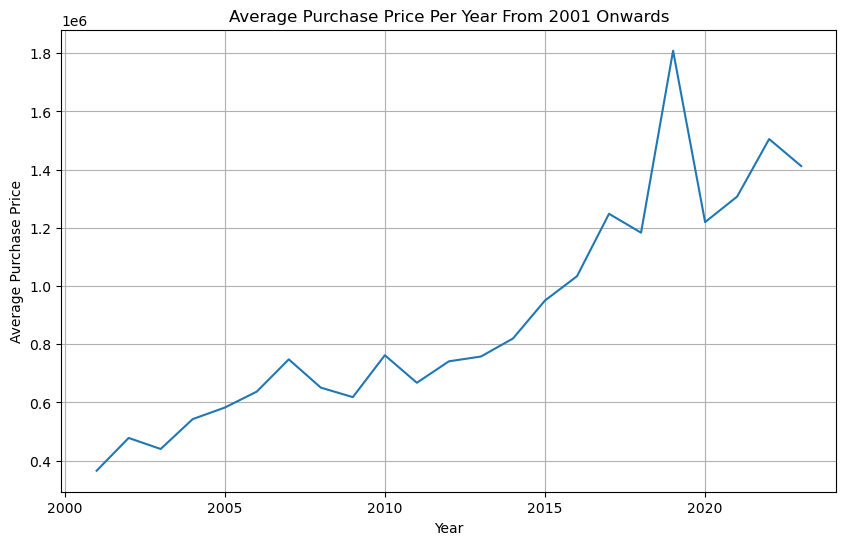

In [43]:
# Plot a line graph
plt.figure(figsize=(10, 6))
plt.plot(average_price_per_year_from_2001.index, average_price_per_year_from_2001.values)
plt.xlabel('Year')
plt.ylabel('Average Purchase Price')
plt.title('Average Purchase Price Per Year From 2001 Onwards')
plt.grid(True)
plt.show()

## Location analysis

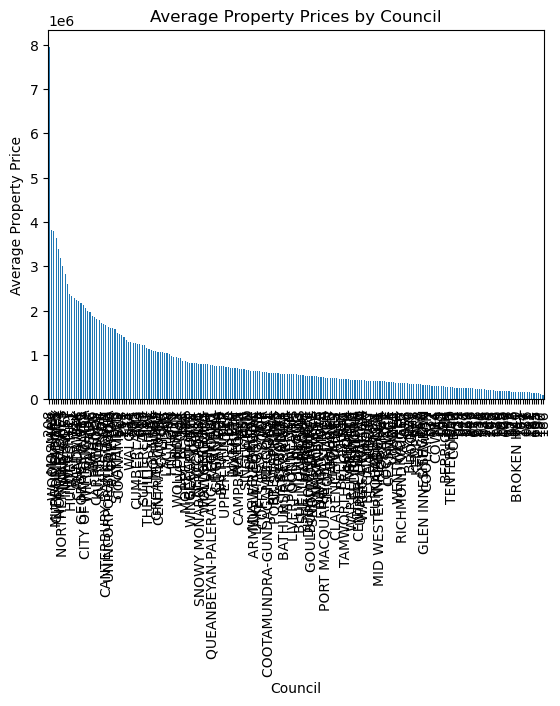

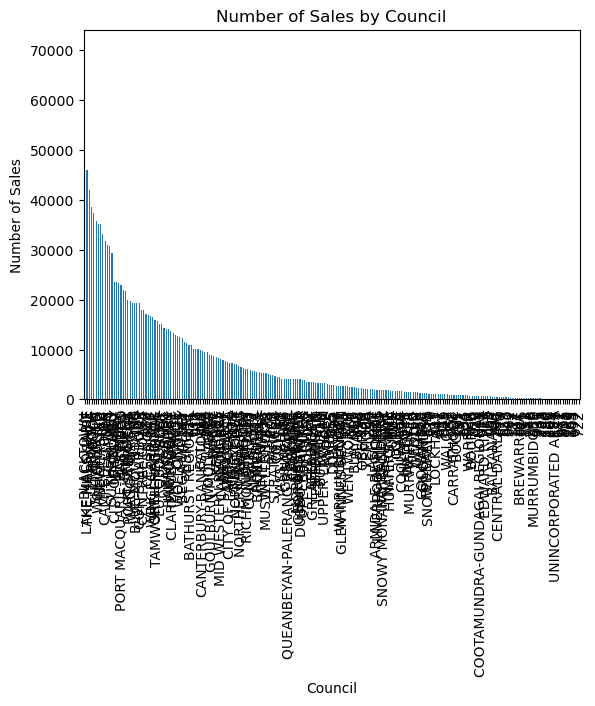

In [46]:
avg_price_by_council = df.groupby('council_name')['purchase_price'].mean().sort_values(ascending=False)
avg_price_by_council.plot(kind='bar')
plt.title('Average Property Prices by Council')
plt.xlabel('Council')
plt.ylabel('Average Property Price')
plt.show()

sales_by_council = df['council_name'].value_counts()
sales_by_council.plot(kind='bar')
plt.title('Number of Sales by Council')
plt.xlabel('Council')
plt.ylabel('Number of Sales')
plt.show()


**show only top 10 councils.**

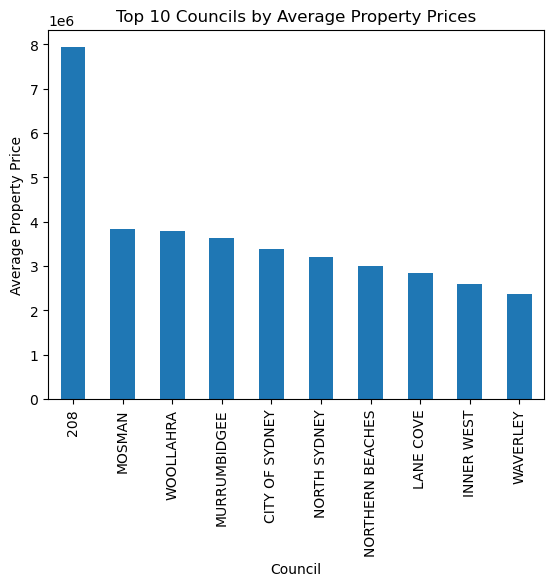

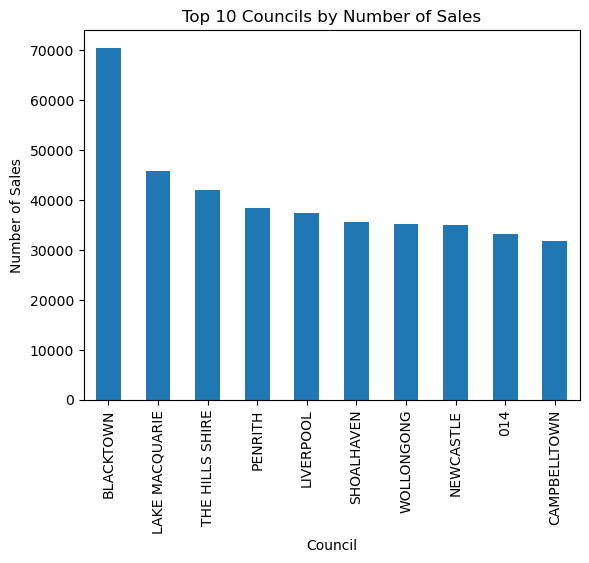

In [47]:
# Average Property Prices by Council (Top 10)
avg_price_by_council = df.groupby('council_name')['purchase_price'].mean().sort_values(ascending=False)[:10]
avg_price_by_council.plot(kind='bar')
plt.title('Top 10 Councils by Average Property Prices')
plt.xlabel('Council')
plt.ylabel('Average Property Price')
plt.show()

# Number of Sales by Council (Top 10)
sales_by_council = df['council_name'].value_counts()[:10]
sales_by_council.plot(kind='bar')
plt.title('Top 10 Councils by Number of Sales')
plt.xlabel('Council')
plt.ylabel('Number of Sales')
plt.show()


## Property Type Analysis

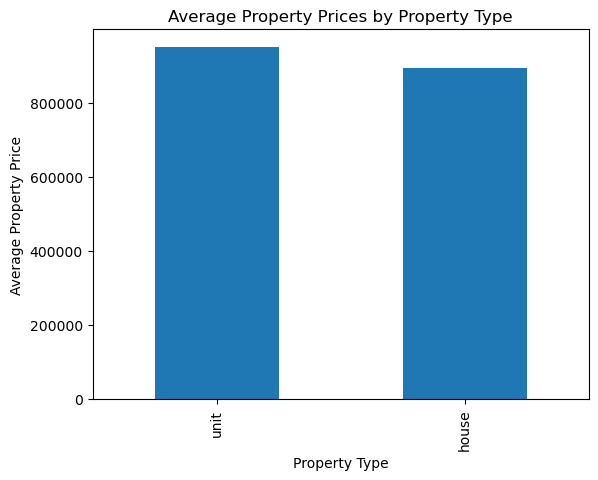

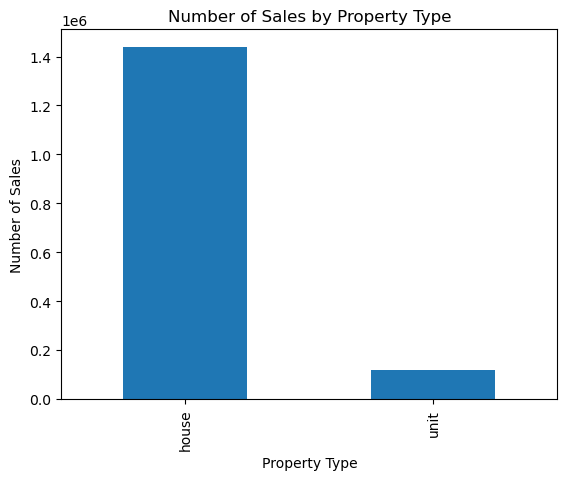

In [48]:
avg_price_by_property_type = df.groupby('property_type')['purchase_price'].mean().sort_values(ascending=False)
avg_price_by_property_type.plot(kind='bar')
plt.title('Average Property Prices by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Property Price')
plt.show()

common_property_types = df['property_type'].value_counts()
common_property_types.plot(kind='bar')
plt.title('Number of Sales by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Number of Sales')
plt.show()


## Nature of Property Analysis

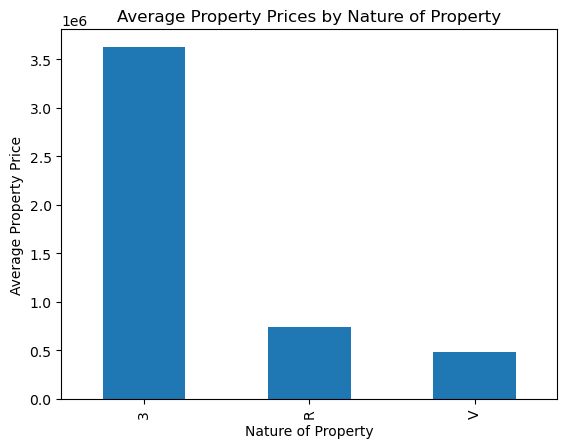

In [49]:
avg_price_by_nature = df.groupby('nature_of_property')['purchase_price'].mean().sort_values(ascending=False)
avg_price_by_nature.plot(kind='bar')
plt.title('Average Property Prices by Nature of Property')
plt.xlabel('Nature of Property')
plt.ylabel('Average Property Price')
plt.show()


## Correlation Analysis

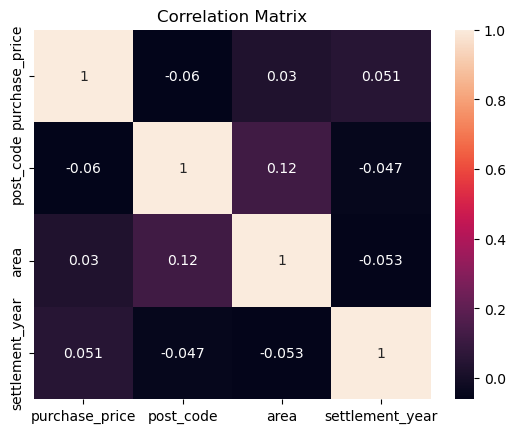

In [50]:
import seaborn as sns

correlation = df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation, annot=True)
plt.title('Correlation Matrix')
plt.show()


## Seasonality Analysis

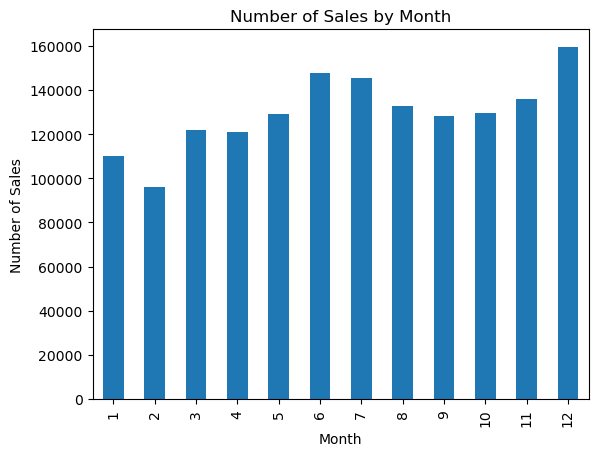

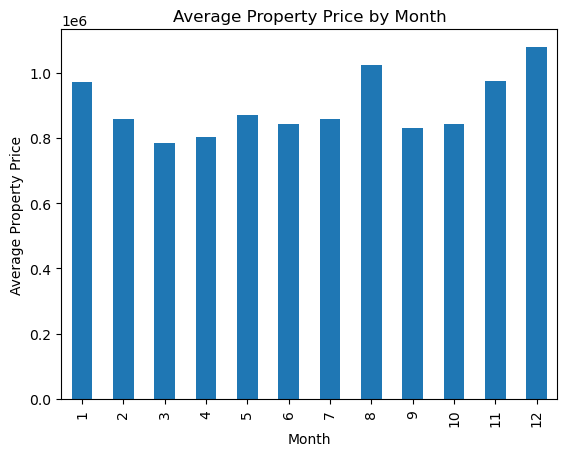

In [51]:
# Add a 'month' column to the DataFrame
df['month'] = df['settlement_date'].dt.month

# Number of sales per month
sales_per_month = df['month'].value_counts().sort_index()
sales_per_month.plot(kind='bar')
plt.title('Number of Sales by Month')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.show()

# Average price per month
avg_price_per_month = df.groupby('month')['purchase_price'].mean()
avg_price_per_month.plot(kind='bar')
plt.title('Average Property Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Property Price')
plt.show()

## Area-Price correlation

Correlation between area and price: 0.030183615332774857


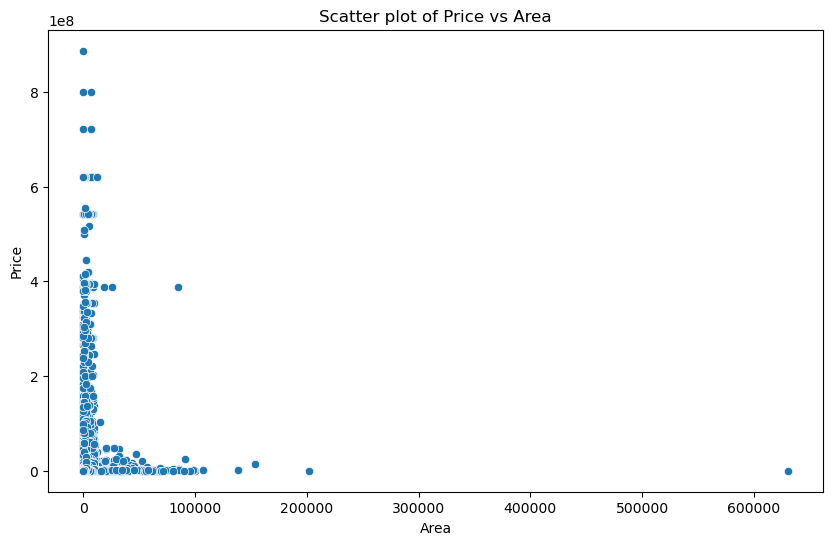

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation between area and price
correlation = df['area'].corr(df['purchase_price'])
print(f'Correlation between area and price: {correlation}')

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='purchase_price', data=df)
plt.title('Scatter plot of Price vs Area')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()


## Price Prediction

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assume we only use 'area' to predict 'purchase_price'
X = df[['area']]
y = df['purchase_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred

array([790288.00745092, 979433.21105584, 859932.40477322, ...,
       787022.45838761, 886201.3428119 , 790608.07255785])